# Clone repo to access resources

In [0]:
!git clone https://github.com/idealo/cnn-exposed.git

Cloning into 'cnn-exposed'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [0]:
cd cnn-exposed/

/content/cnn-exposed


# Setup

In [0]:
# import packages
import os
import pathlib
import requests

import numpy as np
import matplotlib.image as mpimg

from PIL import Image
from io import BytesIO
from skimage import feature, transform
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
%matplotlib inline

# import keras dependencies
from keras.models import Model
from keras.applications import MobileNet as CNN
from keras.applications.mobilenet import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


### Declare some helper functions

In [0]:
def plot_single_image(image_path, fig_size=(10, 10), dpi=100):
    figure(figsize=fig_size, dpi=dpi)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    

# Plotting function for saliency maps
def plot_custom(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r')
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = -abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='bicubic', cmap=cmap, vmin=abs_min, vmax=abs_max)
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='bicubic', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis


def plot_comparison(target_image_path, map_array, title=''):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26, 20))

    img_orig = Image.open(target_image_path).resize((224, 224))
    xi = (map_array[0,:] - np.min(map_array[0,:]))
    xi /= np.max(xi)

    ax = axes.flatten()[0]
    ax.imshow(img_orig)
    ax.set_title('Original', fontdict={'fontsize': 20})
    ax.axis('off')

    plot_custom(attributions[0], xi = xi, axis=axes[1], dilation=.5, percentile=99, alpha=.2).set_title(title, fontdict={'fontsize': 20})
    plt.show()

    
def plot_gradcam(original_image_path, loaded_image, grads):
    fig, axs = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True)

    img_orig = Image.open(original_image_path).resize((224, 224))
    axs[0].imshow(img_orig, aspect='auto')
    axs[0].grid(False)

    axs[1].imshow(overlay(grads, loaded_image), aspect='auto')
    axs[1].grid(False)

In [0]:
path_resources = pathlib.Path('resources/attribution/')

# Attribution approaches

Several approaches:


1.   **Perturbation based approaches** - Occlude area of interest to test its effectiveness in changing predictions
2.   **Gradient bases approaches** - Calculation of gradients of output w.r.t. some network variable
  * *Saliency Maps*
  * Guided Backpropagation
  * Deconvolution
3.   **Relevance Score approaches**
  * *Class Activation Map (CAM)*
  * *Grad- CAM*



# Image classification
We wish to classify the below image with true label for the dog breed: Australian Terrier

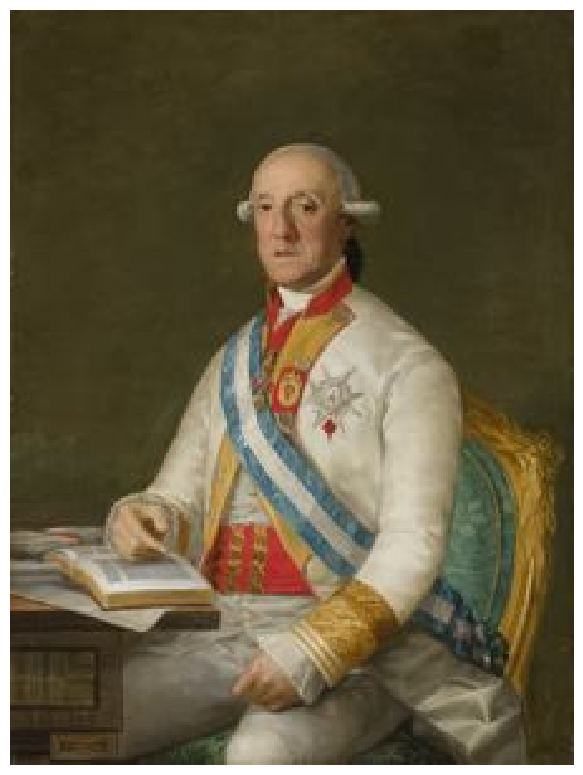

In [0]:
target_image = '/content/1938-244.png'
plot_single_image(target_image)

# Saliency Maps
## Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps
by Simonyan, Vedaldi, Zisserman

(https://arxiv.org/pdf/1312.6034v2.pdf)

### Take gradient of output w.r.t each input

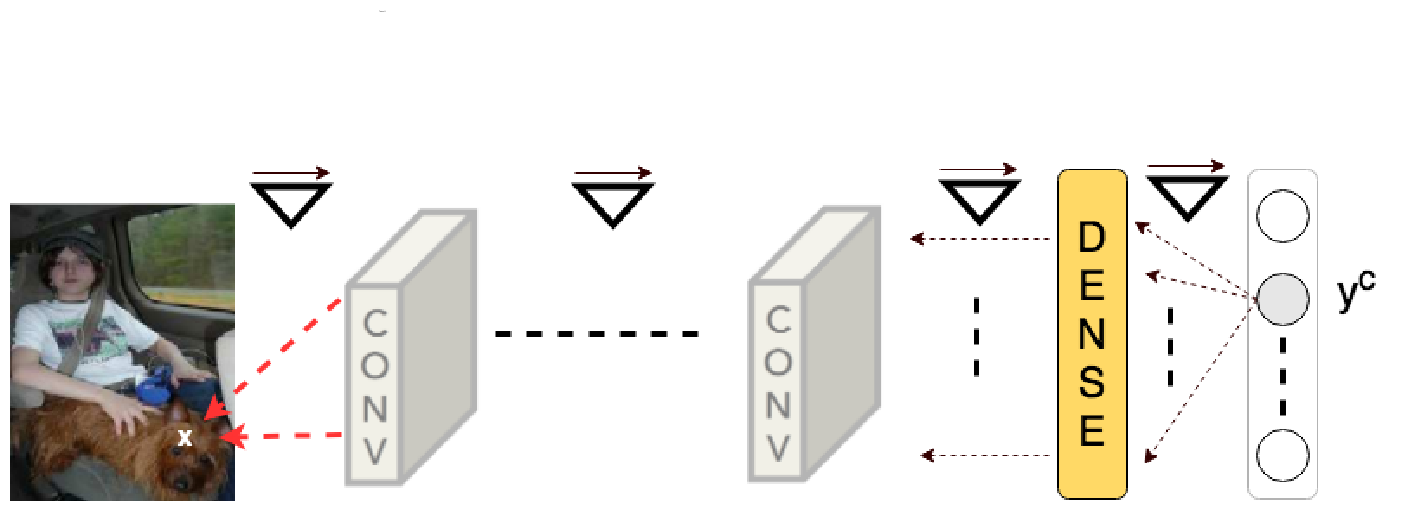

In [0]:
saliency_diagram = os.path.join(path_resources, 'saliency.png')
plot_single_image(saliency_diagram, fig_size=(18, 18))

## Python package: DeepExplain
(https://github.com/marcoancona/DeepExplain#egg=deepexplain)

In [0]:
# Get the model (Mobilenet Pretrained on ImageNet dataset)
model = CNN(include_top=True)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
17227776/17225924 [==============================] - 1s 0us/step


In [0]:
# Get the prediction
loaded_image = np.array(image.load_img(target_image, target_size=(224, 224)))
processed_image = preprocess_input(loaded_image)
preds = model.predict(processed_image[np.newaxis, :])
preds_name = decode_predictions(preds)
preds_name

40960/35363 [==================================] - 0s 0us/step


[[('n03998194', 'prayer_rug', 0.20866302),
  ('n04350905', 'suit', 0.07464201),
  ('n04591157', 'Windsor_tie', 0.06934858),
  ('n06596364', 'comic_book', 0.059204295),
  ('n04599235', 'wool', 0.032100648)]]

## Install Deepexplain package for plotting saliency maps

In [0]:
!pip install git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

  Cloning https://github.com/marcoancona/DeepExplain.git to /tmp/pip-install-cxdqwimv/deepexplain
  Running command git clone -q https://github.com/marcoancona/DeepExplain.git /tmp/pip-install-cxdqwimv/deepexplain
  Created wheel for deepexplain: filename=deepexplain-0.3-cp36-none-any.whl size=15191 sha256=4de1c3c3c827dcd900c07c8c04ef07a4fc043cc19fe9e88542f464c33bbd5845
  Stored in directory: /tmp/pip-ephem-wheel-cache-fvyu1o70/wheels/f1/c2/ef/9e5a9bfb44280495fbe13e7ab8b1ccd0326796d94240f6a028
Successfully built deepexplain


In [0]:
# import deepexplain to draw saliency maps
from deepexplain.tensorflow import DeepExplain

In [0]:
# Get saliency map
# Refer the API documentation for using deepexplain as below
with DeepExplain(session=K.get_session()) as de:
    model = CNN(include_top=True)
    input_tensor = model.layers[0].input
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    top_idx = preds.argsort()[::-1]
    ys = to_categorical(top_idx, num_classes=1000)
    xs = np.tile(processed_image, (1, 1, 1, 1))
    attributions = de.explain('saliency', fModel.outputs[0] * ys, fModel.inputs[0], xs)

/usr/local/lib/python3.6/dist-packages/deepexplain/tensorflow/methods.py:640: UserWarning: Detected unsupported activation (Relu6). This might lead to unexpected or wrong results.
  'This might lead to unexpected or wrong results.' % op.type)
/usr/local/lib/python3.6/dist-packages/deepexplain/tensorflow/methods.py:611: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/skimage/feature/_canny.py:189: RuntimeWarning: invalid value encountered in greater
  eroded_mask = eroded_mask & (magnitude > 0)
/usr/local/lib/python3.6/dist-packages/skimage/feature/_canny.py:198: RuntimeWarning: invalid value encountered in greater_equal
  pts_plus = (isobel >= 0) & (jsobel >= 0) & (abs_isobel >= abs_jsobel)
/usr/local/lib/python3.6/dist-packages/skimage/feature/_canny.py:199: RuntimeWarning: invalid value encountered in less_equal
  pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
/usr/local/lib/python3.6/dist-packages/skimage/feature/_canny.py:199: RuntimeWarning: invalid value encountered in greater_equal
  pts_minus = (isobel <= 0) & (jsobel <= 0) & (abs_isobel >= abs_jsobel)
/usr/local/lib/python3.6/dist-packages/skimage/feature/_canny.py:217: RuntimeWarning: invalid value encount

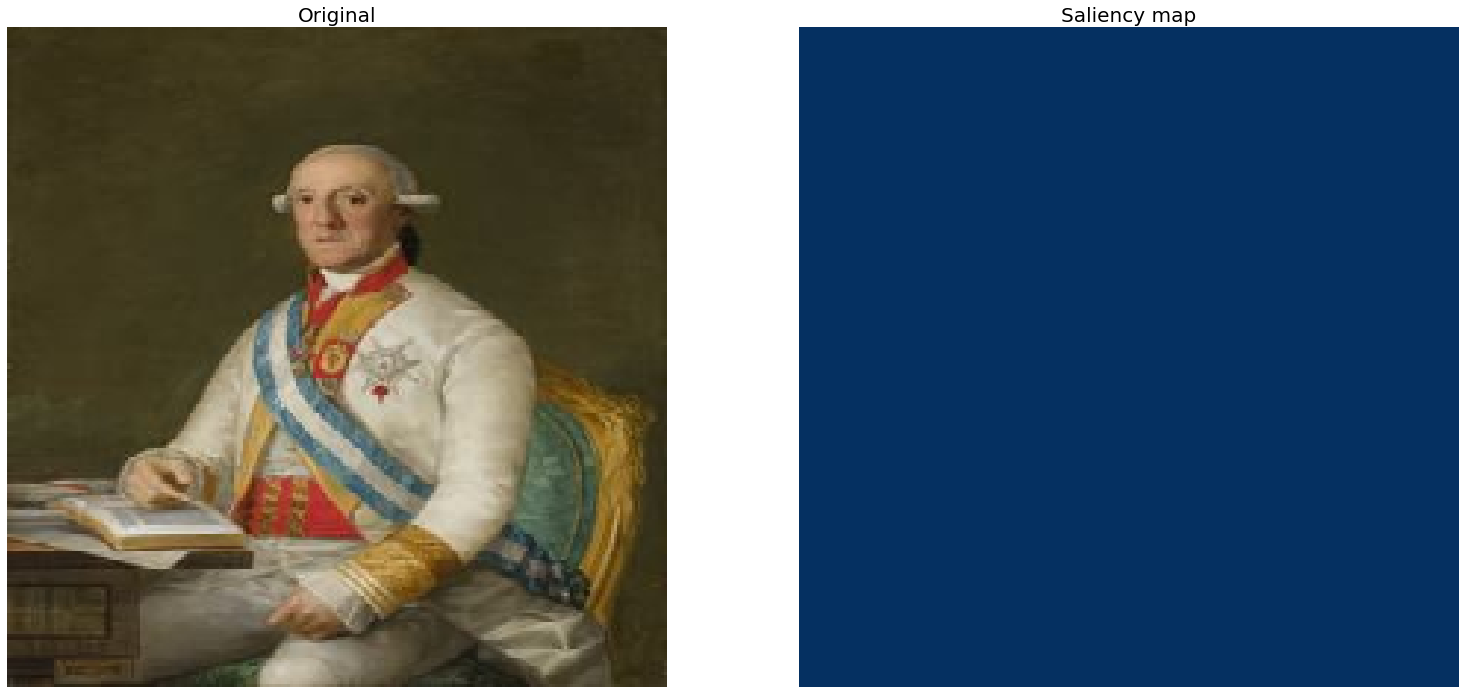

In [0]:
plot_comparison(target_image, attributions, title='Saliency map')

## Saliency Map Pros:

*   Fine-grained understanding of relative contribution of pixels 

## Saliency Map Cons:
* Propagation of gradient is hard (due to non-linearlities such as relu which makes the gradient discontinuous)

# Class Activation Map (CAM) 
## Learning Deep Features for Discriminative Localization
by Zhou et. al

(http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

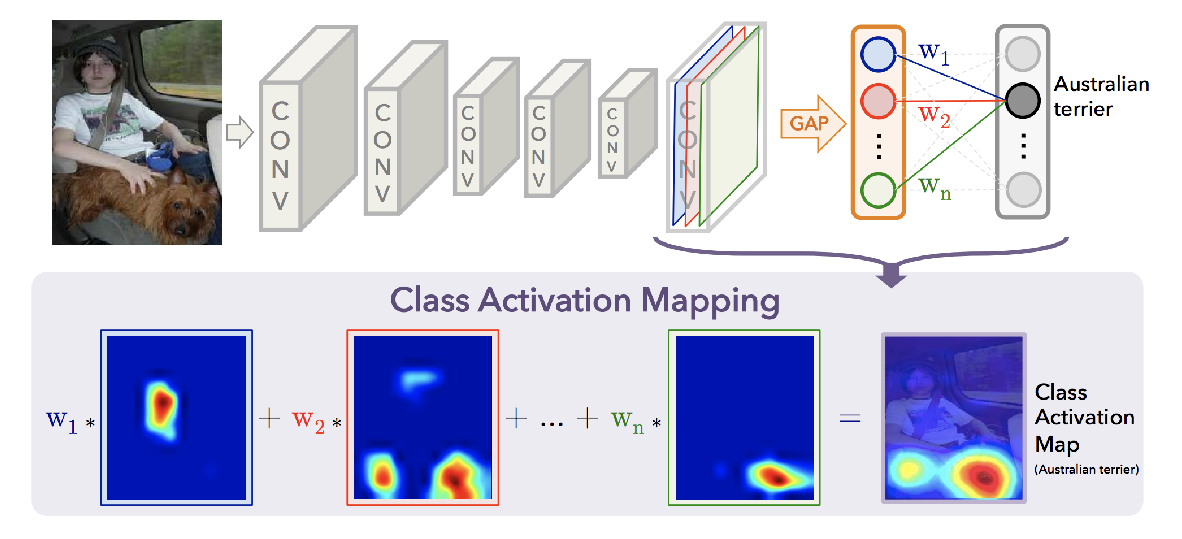

In [0]:
cam_diagram = os.path.join(path_resources, 'cam.png')
plot_single_image(cam_diagram, fig_size=(15, 15))

## CAM Pros:

*   No calculation of gradients needed
*   Intuitive to understand

## CAM Cons:
* Bound to a fixed architecture (Conv -> GAP -> Dense)

# Layerwise Relevance Propagation (LRP) 
## On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation
by Bach et. al. (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140)

In [0]:
lrp_diagram_1 = os.path.join(path_resources, 'lrp_new.png')
plot_single_image(lrp_diagram_1, fig_size=(3, 3), dpi=300) 
print('source: Montavon et. al., Explaining nonlinear classification decisions with deep Taylor decomposition')

In [0]:
lrp_diagram_2 = os.path.join(path_resources, 'lrp.png')
plot_single_image(lrp_diagram_2, fig_size=(4, 4), dpi=300)

In [0]:
# Get Epsilon-LRP heatmap
with DeepExplain(session=K.get_session()) as de:
    model = CNN(include_top=True)
    input_tensor = model.layers[0].input
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    top_idx = preds.argsort()[::-1]
    ys = to_categorical(top_idx, num_classes=1000)
    xs = np.tile(processed_image, (1, 1, 1, 1))
    attributions = de.explain('elrp', fModel.outputs[0] * ys, fModel.inputs[0], xs)

In [0]:
plot_comparison(target_image, attributions, title='Epsilon-LRP')

## Testing out some more images

In [0]:
image_urls = [
    'http://collection.sdmart.org/media/images/2011-2020_Embark_Object_Photos/2011-89.JPG',
    'http://collection.sdmart.org/media/images/1971-1980_Embark_Object_Photos/1972.46.jpeg',
    'http://collection.sdmart.org/media/images/1930-1940_Embark_Object_Photos/1938_36.jpg',
]

In [0]:
images = []
for url in image_urls:
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).resize((224, 224))
    images.append(np.array(image))

images_pp = preprocess_input(np.array(images))

In [0]:
# Get predictions
preds = model.predict(images_pp)
preds_name = decode_predictions(preds)

for j, url in enumerate(image_urls):
    print('{}'.format(url))
    for (i, (imagenetID, label, prob)) in enumerate(preds_name[j]):
        print('{}. {}: {:.2f}%'.format(i + 1, label, prob * 100))
    print('\n')

In [0]:
N_PLOT_PRED = 2 # top-n predictions to plot for each image
K.clear_session()

with DeepExplain(session=K.get_session()) as de:
  
    model = CNN(include_top=True)
    input_tensor = model.layers[0].input
    
  # We target the output of the last dense layer (pre-softmax)
  # To do so, create a new model sharing the same layers until the last dense
    
    fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
    target_tensor = fModel(input_tensor)
    
    for u, url in enumerate(image_urls):
        print('{}:'.format(url))
        top_idx = preds[u].argsort()[-N_PLOT_PRED:][::-1] # Get indices of the top-2 predicted classes

        ys = to_categorical(top_idx, num_classes=1000) # one-hot encode the predicted indices
        xs = np.tile(images_pp[u], (N_PLOT_PRED, 1, 1, 1)) # Duplicate the image N_PLOT_PRED number of times
        
        # Draw saliency maps and Epsilon-LRP heatmap
        attributions = {
            'Saliency maps': de.explain('saliency', fModel.outputs[0] * ys, fModel.inputs[0], xs),
            'Epsilon-LRP': de.explain('elrp', fModel.outputs[0] * ys, fModel.inputs[0], xs),
        }
        print ('Done!')
        
        # Plotting Function
        n_cols = int(len(attributions)) + 1
        n_rows = 1

        for i, xi in enumerate(xs):
            print('{}: {:.2f}%'.format(preds_name[u][i][1], preds_name[u][i][2] * 100))

            fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5*n_cols, 5*n_rows))

            xi = (xi - np.min(xi))
            xi /= np.max(xi)
            ax = axes.flatten()[0]
            ax.imshow(images[u])
            ax.set_title('Original')
            ax.axis('off')

            for j, a in enumerate(attributions):
                axj = axes.flatten()[j + 1]
                plot_custom(attributions[a][i], xi = xi, axis=axj, dilation=.5, percentile=99, alpha=.2).set_title(a)
        plt.show()
        plt.close()